In [2]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter
import pingouin as pg
from scipy import fft

import multiprocessing as mp


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [3]:
def fft_of_data(data,dt):
    data = data-np.mean(data)
    N = data.shape[0] # Length of data.
    try:
        yf = 2.0/N * (fft.fft(data)[0:N//2])
    except ZeroDivisionError:
        yf= 0

    xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.

    return(xf, yf) # xf = frequency array. yf = amplitude or power.


In [4]:
def calculate_unit_vector(point):
    norm = np.linalg.norm(point)
    return point / norm if norm != 0 else point

def calculate_vector_components(v, u):
    u_norm = u / np.linalg.norm(u)
    v_dot_u = np.dot(v, u_norm)
    v_parallel = v_dot_u * u_norm
    v_perpendicular = v - v_parallel
    return v_parallel, v_perpendicular

In [5]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [33]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
df2 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf(dir+'Forest/ForestMASigned.h5')


In [34]:
# df=pd.concat([df1,df2,df3])
# df.reset_index(inplace=True, drop=True)

### Vector projection Anaylsis

In [42]:
dat=pd.DataFrame()
dat=df3
points = dat[['xsrc', 'ysrc']].values
velocities = dat[['gps_linear_x', 'gps_linear_y']].values

unit_vectors = np.apply_along_axis(calculate_unit_vector, 1, points)
parallels = []
perpendiculars = []

for v, u in zip(velocities, unit_vectors):
    v_parallel, v_perpendicular = calculate_vector_components(v, u)
    parallels.append(v_parallel)
    perpendiculars.append(v_perpendicular)

# Convert the results to numpy arrays for easier handling
parallels = np.array(parallels)
perpendiculars = np.array(perpendiculars)

# Add the results to the DataFrame
dat['unit_x'], dat['unit_y'] = unit_vectors[:, 0], unit_vectors[:, 1]
dat['parallel_x'], dat['parallel_y'] = parallels[:, 0], parallels[:, 1]
dat['perpendicular_x'], dat['perpendicular_y'] = perpendiculars[:, 0], perpendiculars[:, 1]

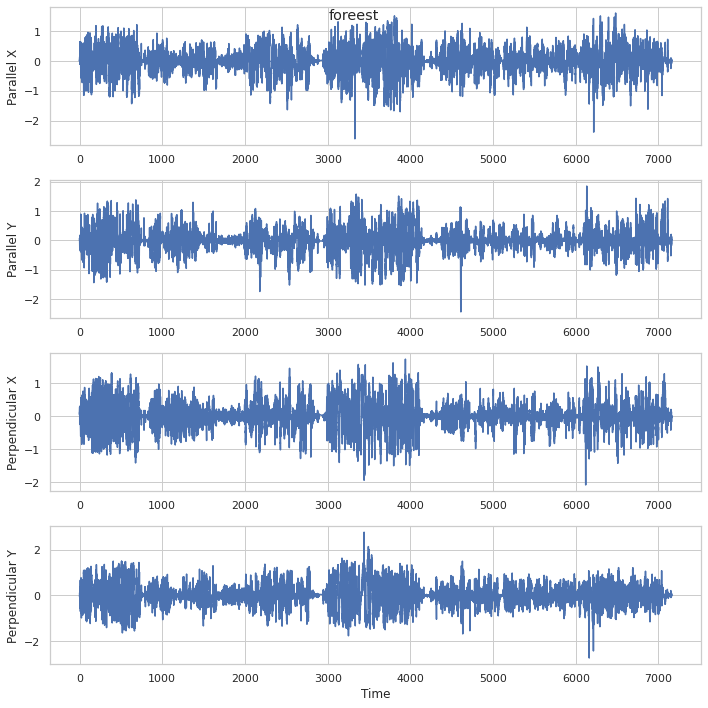

In [43]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# Plot parallel_x
axs[0].plot(dat.time, dat.parallel_x)
axs[0].set_ylabel('Parallel X')

# Plot parallel_y
axs[1].plot(dat.time, dat.parallel_y)
axs[1].set_ylabel('Parallel Y')

# Plot perpendicular_x
axs[2].plot(dat.time, dat.perpendicular_x)
axs[2].set_ylabel('Perpendicular X')

# Plot perpendicular_y
axs[3].plot(dat.time, dat.perpendicular_y)
axs[3].set_ylabel('Perpendicular Y')

# Set common x-axis label
axs[-1].set_xlabel('Time')
fig.tight_layout()
fig.suptitle('foreest')
fig.savefig('../../Figure/timeseriesforest.jpeg', dpi=300, bbox_inches = "tight")

In [20]:
# dat=df2
# x=dat.xsrc
# y=dat.ysrc
# xdot = dat.gps_linear_x
# ydot = dat.gps_linear_y

# def wrapped_angular_diff(a, b):
#     return np.arctan2(np.sin(a-b), np.cos(a-b))

# r = np.sqrt(x**2 + y**2)
# theta = np.arctan2(y,x)

# rdot=(xdot * np.cos(theta) + ydot * np.sin(theta))
# thetadot = (ydot * np.cos(theta) - xdot * np.sin(theta)) / r

# result = pd.DataFrame({'r': r, 'theta': theta, 'r_dot': rdot, 'theta_dot': thetadot})


In [44]:
dt = dat.time[1] - dat.time[0]

f_parallel_x, parallel_x_fft = fft_of_data(np.array(dat.parallel_x), dt)
f_parallel_y, parallel_y_fft = fft_of_data(np.array(dat.parallel_y), dt)
f_perpendicular_x, perpendicular_x_fft = fft_of_data(np.array(dat.perpendicular_x), dt)
f_perpendicular_y, perpendicular_y_fft = fft_of_data(np.array(dat.perpendicular_y), dt)


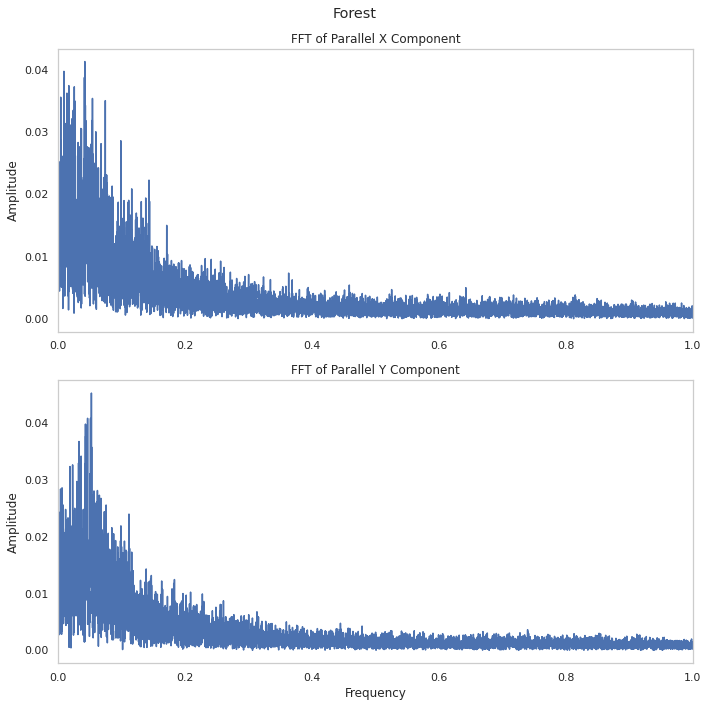

In [45]:
# Plot the FFT results for parallel components
f, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(f_parallel_x, np.abs(parallel_x_fft))
axs[0].set_ylabel('Amplitude')
axs[0].set_title('FFT of Parallel X Component')
axs[0].grid(False)

axs[1].plot(f_parallel_y, np.abs(parallel_y_fft))
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('FFT of Parallel Y Component')
axs[1].grid(False)

axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)

f.suptitle('Forest')
f.tight_layout()
f.savefig('../../Figure/Parallelforest.jpeg', dpi=300, bbox_inches="tight")

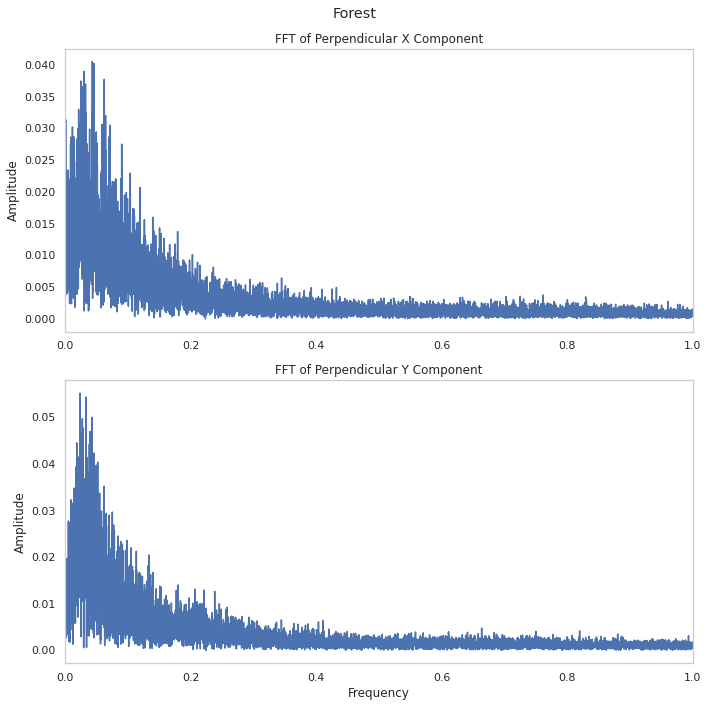

In [46]:
# Plot the FFT results for perpendicular components
f, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(f_perpendicular_x, np.abs(perpendicular_x_fft))
axs[0].set_ylabel('Amplitude')
axs[0].set_title('FFT of Perpendicular X Component')
axs[0].grid(False)

axs[1].plot(f_perpendicular_y, np.abs(perpendicular_y_fft))
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('FFT of Perpendicular Y Component')
axs[1].grid(False)

axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)

f.suptitle('Forest')
f.tight_layout()
f.savefig('../../Figure/PerpendicularForest.jpeg', dpi=300, bbox_inches="tight")


/tmp/ipykernel_45515/1223378996.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f1), np.log10(rdot_fft), label='r_dot')
/home/gadfly/DataAnalysis/pyresearch/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_45515/1223378996.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f2), np.log10(thetadot_fft), label='theta_dot', alpha=0.6)
/home/gadfly/DataAnalysis/pyresearch/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


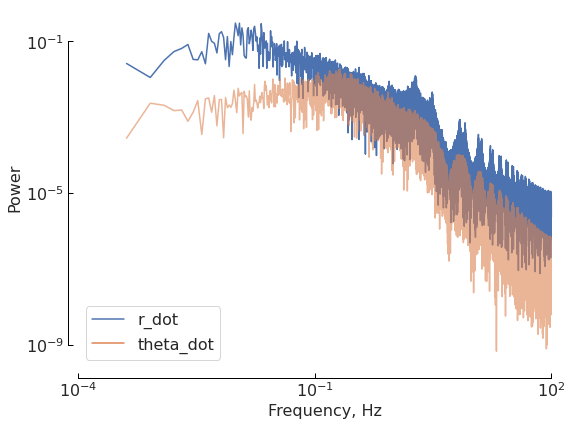

In [25]:
f,ax = plt.subplots(1,1, figsize=(8,6))

# ax.axvspan(-3.5, -1,  alpha=0.2)
# ax.axvline(1, color='r')
ax.plot(np.log10(f1), np.log10(rdot_fft), label='r_dot')
ax.plot(np.log10(f2), np.log10(thetadot_fft), label='theta_dot', alpha=0.6)

ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Power')
ax.grid(False)



mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
                            smart_bounds=True, xticks=[-4,-1,2],yticks=[-9,-5,-1],linewidth=1)
ax.set_xticklabels([r'$10^{-4}$',r'$10^{-1}$', r'$10^{2}$'])
ax.set_yticklabels([r'$10^{-9}$',r'$10^{-5}$', r'$10^{-1}$'])

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)

# f.suptitle('Trajectory Length = 25 s')

leg = ax.legend(loc='lower left', fontsize=16)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

f.savefig('../../Figure/hws1.jpeg', dpi=300, bbox_inches = "tight")

In [328]:
r_dot_fft = np.fft.fft(result['r_dot'])
theta_dot_fft = np.fft.fft(result['theta_dot'])
dt=result.time[1]-result.time[0]
frequencies = np.fft.fftfreq(len(result['r_dot']), d=dt)[:len(result['r_dot'])//2]
r_dot_fft = r_dot_fft[:len(result['r_dot'])//2]
theta_dot_fft = theta_dot_fft[:len(result['theta_dot'])//2]

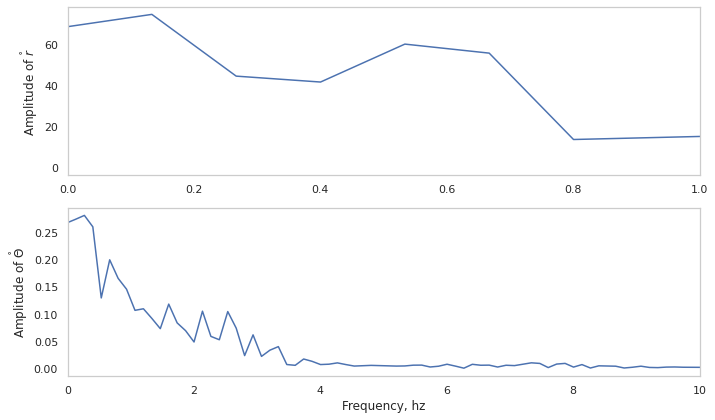

In [329]:

f, ax = plt.subplots(2,1, figsize=(10, 6))

ax[0].grid(False)
ax[0].plot(frequencies, np.abs(r_dot_fft))

ax[0].set_ylabel('Amplitude of $\overset{\circ}{r}$')
# ax[0].set_title('Frequency spectrum of r_dot')
ax[0].set_xlim(0,1)

ax[1].grid(False)
ax[1].plot(frequencies, np.abs(theta_dot_fft))

ax[1].set_xlabel('Frequency, hz')
ax[1].set_ylabel('Amplitude of $\overset{\circ}{\Theta}$')
# ax[1].set_title('Frequency spectrum of theta_dot')
ax[1].set_xlim(0,10)

# f.suptitle('with wrapped_method')
f.tight_layout()
# f.savefig('../../Figure/snippet3.jpeg', dpi=300, bbox_inches = "tight")

/tmp/ipykernel_520608/351222781.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(frequencies), np.log10(np.abs(r_dot_fft)) , label='$\overset{\circ}{r}$')
/tmp/ipykernel_520608/351222781.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(frequencies), np.log10(np.abs(theta_dot_fft)), label='$\overset{\circ}{\Theta}$')


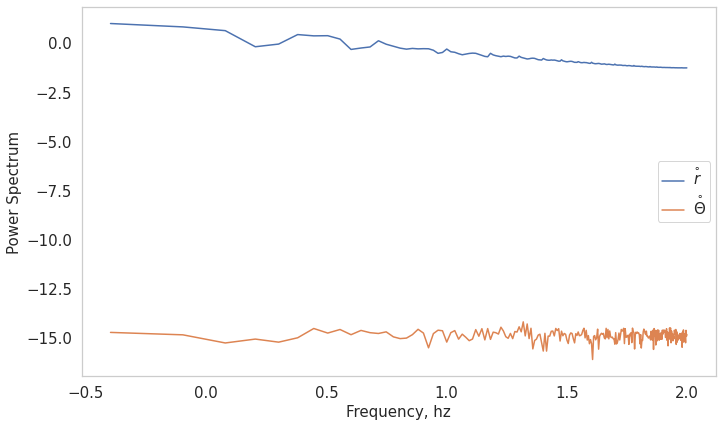

In [293]:
f, ax = plt.subplots(1,1, figsize=(10, 6))

ax.grid(False)
ax.plot(np.log10(frequencies), np.log10(np.abs(r_dot_fft)) , label='$\overset{\circ}{r}$')
ax.plot(np.log10(frequencies), np.log10(np.abs(theta_dot_fft)), label='$\overset{\circ}{\Theta}$')

ax.set_xlabel('Frequency, hz')
ax.set_ylabel('Power Spectrum')

# mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[-3,-1,2],yticks=[-15,-10,0,5],linewidth=1)

# ax.set_xticklabels([r'$10^{-3}$',r'$10^{-1}$', r'$10^{2}$'])
# ax.set_yticklabels([r'$10^{-15}$',r'$10^{-10}$',r'$10^{0}$', r'$10^{5}$'])

ax.legend()

f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/snippet4.jpeg', dpi=300, bbox_inches = "tight")

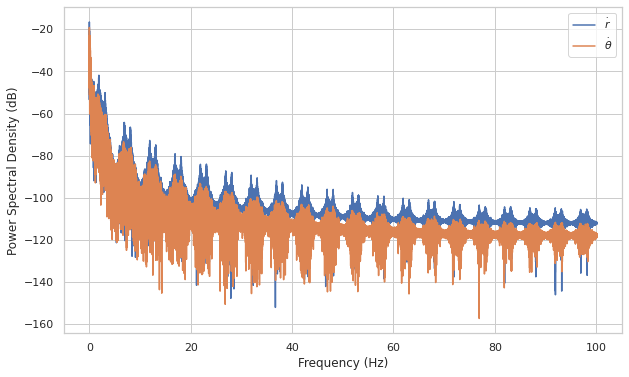

In [109]:
# Compute FFT
r_dot_fft = np.fft.fft(result['r_dot'])
theta_dot_fft = np.fft.fft(result['theta_dot'])

# Compute power spectral density (squared absolute value of FFT)
psd_r_dot = np.abs(r_dot_fft)**2
psd_theta_dot = np.abs(theta_dot_fft)**2

# Normalize the power spectral densities
psd_r_dot /= np.sum(psd_r_dot)
psd_theta_dot /= np.sum(psd_theta_dot)

# Get the frequencies
dt = result.time[1] - result.time[0]
frequencies = np.fft.fftfreq(len(result['r_dot']), d=dt)

# Select only the positive frequencies
frequencies = frequencies[:len(frequencies)//2]
psd_r_dot = psd_r_dot[:len(psd_r_dot)//2]
psd_theta_dot = psd_theta_dot[:len(psd_theta_dot)//2]


r_dot_fft = r_dot_fft[:len(r_dot_fft)//2]
theta_dot_fft = theta_dot_fft[:len(theta_dot_fft)//2]

# Plot on log scale
plt.figure(figsize=(10, 6))
plt.plot(frequencies, 10 * np.log10(psd_r_dot), label='$\dot{r}$')
plt.plot(frequencies, 10 * np.log10(psd_theta_dot), label='$\dot{\\theta}$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.legend()
plt.grid(False)

plt.savefig('../../Figure/power_spec_normalized.jpeg', dpi=300, bbox_inches = "tight")
plt.show()

### Distribution of where we walked relative to the source

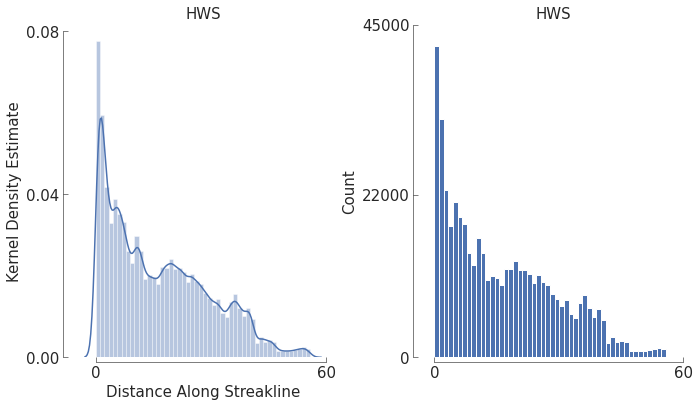

In [71]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(df1.distance_from_source_a*df1.xsign, bins=50, kde=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('Distance Along Streakline')
ax1.set_ylabel('Kernel Density Estimate')
ax1.grid(False)

ax1.set_title('HWS')
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,0.04,0.08],
                            linewidth=0.5)

ax2.hist(df1.distance_from_source_a*df1.xsign, bins=50)
ax2.grid(False)
ax2.set_title('HWS')
ax2.set_ylabel('Count')
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,22000,45000],
                            linewidth=0.5)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/hist_1.jpeg', dpi=300, bbox_inches = "tight")

In [ ]:
# # Initialize two empty lists for r_dot and theta_dot
# r_list = []
# theta_list = []
# r_dot_list = []
# theta_dot_list = []

# # Loop over each row in the DataFrame
# for i in range(len(df1)):
#     # Call the function and store the results
#     r, theta, r_dot, theta_dot = compute_r_dot_theta_dot(df1.iloc[i]['xsrc'], 
#                                                          df1.iloc[i]['ysrc'], df1.iloc[i]['gps_linear_x'], 
#                                                          df1.iloc[i]['gps_linear_y'])

#     # Append the results to the lists
#     r_list.append(r)
#     theta_list.append(theta)
#     r_dot_list.append(r_dot)
#     theta_dot_list.append(theta_dot)

# # Create a new DataFrame with the results
# result = pd.DataFrame({
#     'r' : r_list,
#     'theta' : theta_list,
#     'r_dot': r_dot_list,
#     'theta_dot': theta_dot_list,
# })

# result['time']=df1.time